## Регуляризация

План на сегодня:
1. кривые обучения, overfitting
2. weight decay и ранняя остановка
3. dropout
4. изменение архитектуры сети для использования симметрий данных


In [1]:
from collections import defaultdict
from typing import Callable

import matplotlib.pyplot as plt
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

Matplotlib is building the font cache; this may take a moment.


Сегодня мы хотим понаблюдать за ***переобучением***: ситуацией, когда модель в процессе обучения  начинает реагировать на шумовую составляющую обучающей выборки, а не извлекать полезный сигнал, из-за чего плохо обобщается на новые данные.

Вызвать переобучение можно двумя способами: усложнить модель (увеличить кол-во обучаемых параметров) или уменьшить обучающую выборку, мы для скорости экспериментов пойдём вторым путём и оставим в обучающей выборке 1920 наблюдений:

In [2]:
torch.manual_seed(42)

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

batch_size = 64
# сделаем случайную подвыборку из обучающего датасета
subset_size = batch_size * 30
train_dataset, _ = random_split(
    train_dataset, lengths=[subset_size, len(train_dataset) - subset_size]
)
test_dataset, _ = random_split(
    test_dataset, lengths=[subset_size, len(test_dataset) - subset_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4057947.70it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 147045.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1545023.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2932655.29it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Ниже - наши уже привычные функции для обучения, и функция `run_experiment` с прошлого домашнего задания, чтобы упростить запуск экспериментов с разными гиперпараметрами.

In [3]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
) -> tuple[Tensor, Tensor]:
    model.to(device=device)
    # прогоняем батч через модель
    x, y = batch
    logits = model(x.to(device=device))
    # оцениваем значение ошибки
    loss = F.cross_entropy(logits, y.to(device=device))
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, logits


def train_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    max_batches: int = 100,
    device: str = "cpu",
) -> dict[str, float]:
    model.train()
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        loss, logits = training_step(batch, model, optimizer, device)

        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


@torch.no_grad()
def test_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    max_batches: int = 100,
    device: str = "cpu",
) -> Tensor:
    model.eval()
    model.to(device=device)
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        logits = model(x.to(device=device))
        # оцениваем значение ошибки
        loss = F.cross_entropy(logits, y.to(device=device))
        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


def run_experiment(
    model_gen: Callable[[], nn.Module],
    optim_gen: Callable[[nn.Module], torch.optim.Optimizer],
    seed: int,
    n_epochs: int = 10,
    max_batches: int | None = None,
    verbose: bool = False,
    device: str = "cpu",
) -> dict[str, list[float]]:
    """Функция для запуска экспериментов.

    Args:
        model_gen (Callable[[], nn.Module]): Функция для создания модели
        optim_gen (Callable[[nn.Module], torch.optim.Optimizer]): Функция для создания оптимизатора для модели
        seed (int): random seed
        n_epochs (int, optional): Число эпох обучения. Defaults to 10.
        max_batches (int | None, optional): Если указано, только `max_batches` минибатчей
            будет использоваться при обучении и тестировании. Defaults to None.
        verbose (bool, optional): Выводить ли информацию для отладки. Defaults to False.

    Returns:
        tuple[list[float], list[float]]: Значения ошибки на обучающей и тестовой выборках по всем эпохам
    """
    torch.manual_seed(seed)
    # создадим модель и выведем значение ошибки после инициализации
    model = model_gen()
    optim = optim_gen(model)
    metrics: dict[str, list[float]] = defaultdict(list)
    for i in range(n_epochs):
        train_dict = train_epoch(
            train_loader, model, optim, max_batches=max_batches, device=device
        )
        test_dict = test_epoch(
            test_loader, model, max_batches=max_batches, device=device
        )
        train_loss, train_accuracy = train_dict["loss"], train_dict["accuracy"]
        test_loss, test_accuracy = test_dict["loss"], test_dict["accuracy"]
        if verbose:
            print(
                f"Epoch {i} train: loss = {train_loss:.4f}, accuracy = {train_accuracy:.4f}"
            )
            print(
                f"Epoch {i} test: loss = {test_loss:.4f}, accuracy = {test_accuracy:.4f}"
            )

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["test_losses"].append(test_loss)
        metrics["test_accuracies"].append(test_accuracy)

    return metrics

Модель такая же, как раньше, но сегодня мы опишем её внутреннее устройство немного по-другому - через модуль `nn.Sequential`

In [4]:
input_dim = 784
hidden_dim = 64
n_classes = 10

sequential_model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(input_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, n_classes),
)

# проверяем
x, y = next(iter(test_loader))
sequential_model.forward(x).shape

torch.Size([64, 10])

Сделаем также функцию для удобного создания такой модели:

In [5]:
def create_model(input_dim: int, hidden_dim: int, output_dim: int) -> nn.Module:
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )

### 1. Overfitting: смотрим на графики обучения (learning curves)

Запустим обучение на базовой модели и посмотрим на динамику значений ошибки:

In [6]:
metrics = run_experiment(
    model_gen=lambda: create_model(784, 256, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.005),
    seed=42,
    n_epochs=30,
    verbose=False,
    device="cpu",
)

Минимальная ошибка:        0.3146
Ошибка в конце обучения:   0.5075
Точность в конце обучения: 0.9198


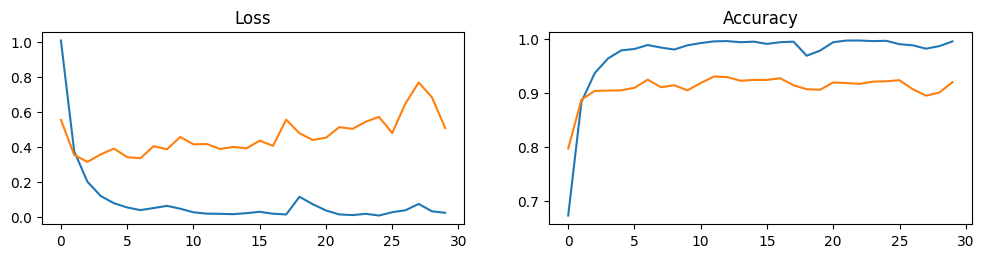

In [7]:
print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

loss_ax.set_title("Loss")
loss_ax.plot(metrics["train_losses"])
loss_ax.plot(metrics["test_losses"])

acc_ax.set_title("Accuracy")
acc_ax.plot(metrics["train_accuracies"])
acc_ax.plot(metrics["test_accuracies"])
plt.show()

Довольно быстро модель начала переобучаться: минимальное значение ошибки на тестовом датасете было достигнуто уже на ~3-й эпохе, после этого ошибка постепенно росла.

### 2. Weight decay

Начнём с, пожалуй, самого простого и в то же время самого действенного метода регуляризации, когда к оптимизируемой ошибке мы добавляем слагаемое с нормой весов модели (вспоминаем ridge-регрессию и lasso-регрессию):

$\mathcal{L}_{WD}(w) = \mathcal{L}(w) + \lambda \Vert w \Vert_2^2$

Технически реализовано это очень просто: достаточно указать значение аргумента `weight_decay` при создании оптимизатора.

In [8]:
metrics = run_experiment(
    model_gen=lambda: create_model(784, 256, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.005, weight_decay=0.0001),
    seed=42,
    n_epochs=30,
    verbose=False,
)

Минимальная ошибка:        0.3071
Ошибка в конце обучения:   0.3617
Точность в конце обучения: 0.9359


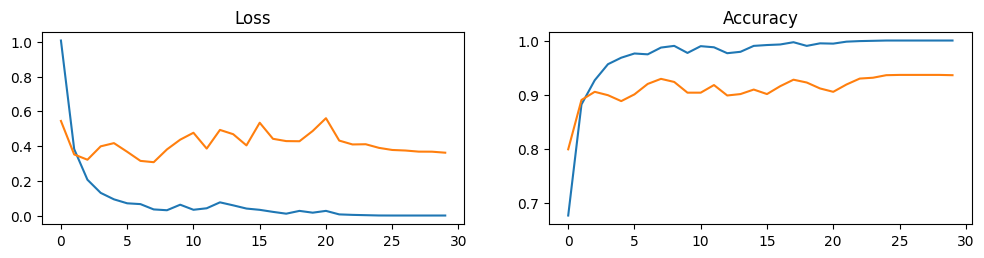

In [9]:
print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

loss_ax.set_title("Loss")
loss_ax.plot(metrics["train_losses"])
loss_ax.plot(metrics["test_losses"])

acc_ax.set_title("Accuracy")
acc_ax.plot(metrics["train_accuracies"])
acc_ax.plot(metrics["test_accuracies"])
plt.show()

### 3. Dropout

<img src="../attachments/dropout.png" width="800">

In [10]:
def create_model(input_dim: int, hidden_dim: int, output_dim: int) -> nn.Module:
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(hidden_dim, output_dim),
    )


metrics = run_experiment(
    model_gen=lambda: create_model(784, 256, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.005, weight_decay=0.000),
    seed=42,
    n_epochs=30,
    verbose=False,
)

Минимальная ошибка:        0.2519
Ошибка в конце обучения:   0.3811
Точность в конце обучения: 0.9271


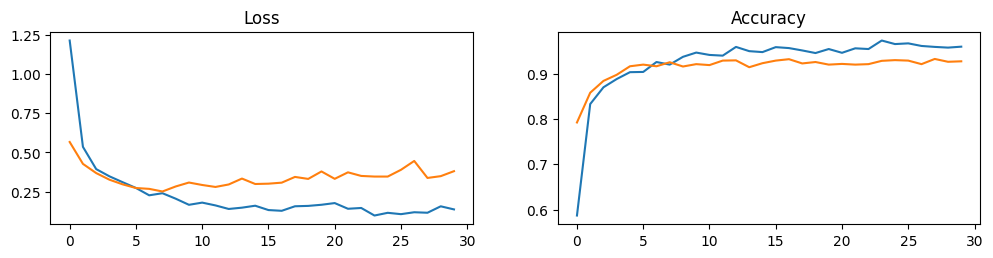

In [11]:
print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

loss_ax.set_title("Loss")
loss_ax.plot(metrics["train_losses"])
loss_ax.plot(metrics["test_losses"])

acc_ax.set_title("Accuracy")
acc_ax.plot(metrics["train_accuracies"])
acc_ax.plot(metrics["test_accuracies"])
plt.show()

### 4. BatchNorm как способ регуляризации

В прошлый раз мы использовали BatchNorm для исправления распределения активаций. У него есть ещё одно полезное свойство: раз наши активации зависят от других примеров в батче, а батч формируется случайным образом, то мы как-будто добавляем небольшой шум к активациям и учим модель быть к нему устойчивой. Это работает как своеобразная регуляризация.

NB: В модели ниже в линейных слоях, непосредственно следующих перед нормализациями, мы убрали параметры свободных членов (bias). Утверждается, что результат от этого не изменится. Почему?

In [12]:
def create_model(input_dim: int, hidden_dim: int, output_dim: int) -> nn.Module:
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(input_dim, hidden_dim, bias=False),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim, bias=False),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
    )


metrics = run_experiment(
    model_gen=lambda: create_model(784, 256, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.005, weight_decay=0.000),
    seed=42,
    n_epochs=30,
    verbose=False,
)

Минимальная ошибка:        0.2665
Ошибка в конце обучения:   0.3608
Точность в конце обучения: 0.9286


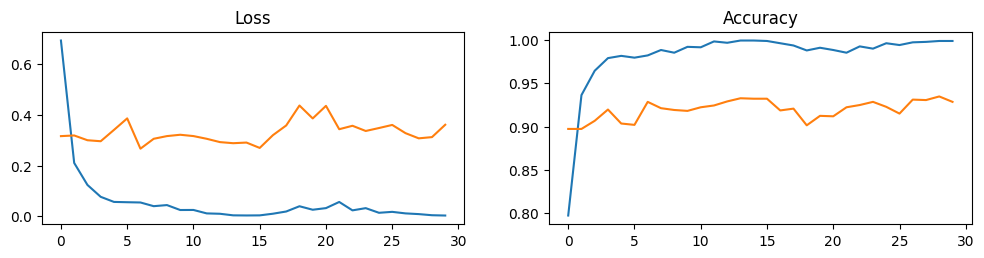

In [13]:
print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

loss_ax.set_title("Loss")
loss_ax.plot(metrics["train_losses"])
loss_ax.plot(metrics["test_losses"])

acc_ax.set_title("Accuracy")
acc_ax.plot(metrics["train_accuracies"])
acc_ax.plot(metrics["test_accuracies"])
plt.show()

### 5. Использование инвариантностей в данных: CNN

Одна из основных причин переобучения - большое количество параметров модели.


In [14]:
sum(p.numel() for p in create_model(784, 256, 10).parameters())

269834

Можем ли мы его уменьшить, сохранив выразительную силу модели? Можем, если заложим в саму архитектуру модели что-то взамен, какой-то inductive bias.

Некоторые преобразования входных данных не меняют их определённые свойства. Иногда инвариантность к таким преобразованиям можно внедрить в архитектуру модели.

Сейчас за обработку каждого участка изображения у нас отвечает свой набор параметров. Что если мы вместо этого будем применять один и тот же набор параметров к каждому кусочку изображения?

<img src="../attachments/conv-pad.svg" style="background:white" width="400"/>

На устройстве свёрточный сетей (и блока `nn.Conv2d` в частности) мы подробно остановимся в следующей практике, а пока просто посмотрим, насколько лучшего результата они позволяют добиться:

In [15]:
def create_model(input_dim: int, hidden_dim: int, output_dim: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=7, stride=3),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, hidden_dim, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Flatten(1),
        nn.Linear(hidden_dim, output_dim),
    )

In [16]:
sum(p.numel() for p in create_model(784, 64, 10).parameters())

24586

In [17]:
metrics = run_experiment(
    model_gen=lambda: create_model(784, 64, 10),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.005, weight_decay=0.0001),
    seed=42,
    n_epochs=30,
    verbose=False,
)

Минимальная ошибка:        0.2091
Ошибка в конце обучения:   0.2587
Точность в конце обучения: 0.9505


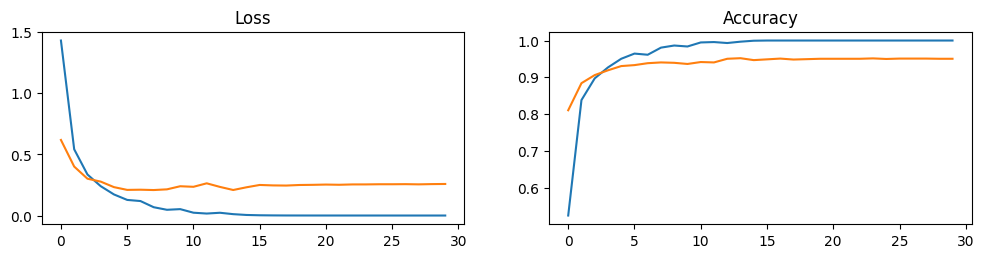

In [18]:
print(f'Минимальная ошибка:        {min(metrics["test_losses"]):.4f}')
print(f'Ошибка в конце обучения:   {metrics["test_losses"][-1]:.4f}')
print(f'Точность в конце обучения: {metrics["test_accuracies"][-1]:.4f}')
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(12, 2.5))

loss_ax.set_title("Loss")
loss_ax.plot(metrics["train_losses"])
loss_ax.plot(metrics["test_losses"])

acc_ax.set_title("Accuracy")
acc_ax.plot(metrics["train_accuracies"])
acc_ax.plot(metrics["test_accuracies"])
plt.show()